# **부분범위처리의 원리**

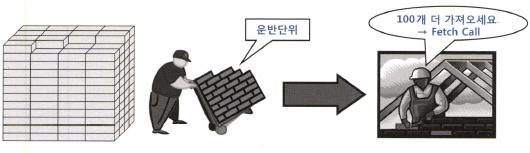

- 전체 데이터를 쉼 없이 연속적으로 처리하지 않고 사용자로부터 Fetch Call이 있을때마다 일정량씩 나누어서 전송.
- 전체 결과집합 중 아직 전송하지 않은 분량이 많이 남아있어도 클리이언트로부터 추가 Fetch Call을 받기 전까지는 그대로 멈춰 서서 기다림.
- 전체 일량을 줄이는 것과는 상관이 없지만, OLTP환경등 일부 데이터만 먼저 보여지고자 할때 유용하게 사용
- DBMS는 데이터를 클라이언트에게 전송할 때 일정량씩 나누어 전송.

**오라클 내 부분범위처리 작동 원리**


- [ArraySize](또는 [FetchSize]) 설정을 통해 운반단위를 조절.
- 내부적으로 데이터는 네트워크 패킷 단위로 단편화되어 여러 번에 걸쳐 나누어 전송.
  - 부분범위처리 내에 또 다른 부분범위처리가 작동.
  - 패킷으로 단편화했기에 유실이나 에러가 발생했을 때 부분 재전송을 통해 복구할 수 있음.
- Array 버퍼는 클라이언트(Client Side)에 위치하며, 서버 측에서는 SUD에 버퍼링이 이루어짐.

**구조 : OSI 7 레이어**

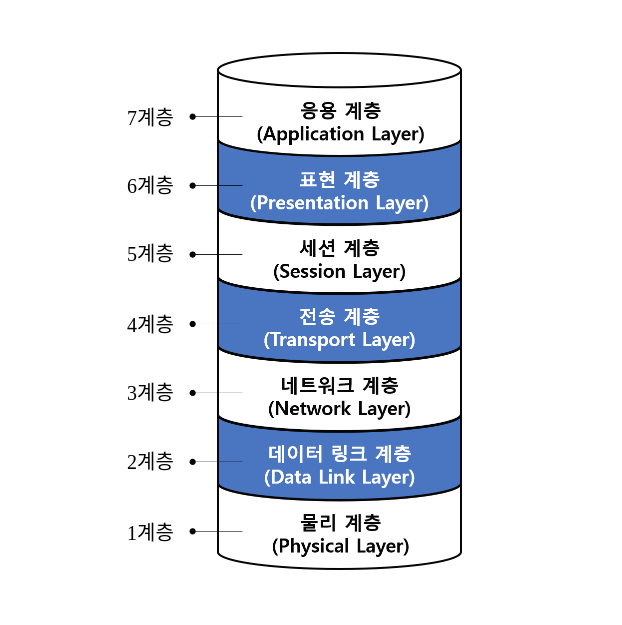

- 오라클서버와 클라이언트는 Application레이어에 위치.
  - 그 아래에 있는 레이어를 통해 서로 데이터를 주고받음.
- SUD와 TDU 사이즈는 TNSNAMES.ORA, LISTENER.ORA 파일에서 아래와 같이 설정 가능하며, 이들의 기본 설정 값은 2KB.
  - (SDU=2048)(TDU=2048)

1. Array 버퍼는 클라이언트(Client Side)에 위치.
2. 서버 측에서는 SUD(Session Data Unit)에 버퍼링이 이루어짐.
  - SDU :네트워크를 통해 전송하기 전에 Oracle Net이 데이터를 담아 두려고 사용하는 버퍼
  - SDU : 서버 측에서 클라이언트로부터 Fetch Call을 기다리는데, Oracle Net이 서버 프로세스로 부터 전송명령을 받을 때까지 대기하는 곳.
  - Oracle Net은 서버 프로세스로부터 전송요청을 받기 전이라도 SDU가 다 차면 버퍼에 쌓인 데이터를 전송하며 클라이언트로부터 Fetch Call을 기다리지 않고 곧이어 데이터를 받아 SDU를 계속 채워나감.
3. TDU(Transport Data Unit) : Transport 레이어 데이터 버퍼에 대한 규격이다.
  - 물리적인 하부 레이어.
  - 내려보내기 전에 데이터를 잘게 쪼개어 클라이언트에게 전송되는 도중에 유실이나 에러가 없도록 제어하는 역할.

# **OLTP 환경에서 부분범위처리에 의한 성능개선 원리**

**ex.1**

- 테이블 생성

```
create table t ( x NUMBER   not null , y NUMBER   not null ) ;
-- 데이터 insert(랜덤으로)
insert into t
select *
from ( select rownum x, rownum y from dual connect by level <= 5000000 )
order by dbms_random.value ;

alter table t add constraint t_pk primary key (x);
alter system flush buffer_cache;

-- 6건 검색
select /*+ index(t t_pk) */ x, y
from   t where  x >  0 and y <= 6 ;

-- 1건 검색
select /*+ index(t t_pk) */ x, y
from   t where  x >  0 and    y <= 1 ;
```

- 운반단위가 5일때
  - 첫번째 Fetch Call
    - 인덱스를 따라 x컬럼 값이 1~5인 5개의 레코드는 테이블 필터 조건인 y<=6조건도 만족.
    - 지체 없이 전송 명령을 통해 클라이언트에게 전송하고, 클라이언트는 Array 버퍼에 담긴 5개의 레코드를 곧바로 화면에 출력.
  - 두번째 Fetch Call
    - 두번째 Fetch Call 명령을 받자마자 x=y=6인 레코드를 찾아 Oracle Net으로 내려보냄.
    - 이제 조건에 더이상 만족하는 레코드가 없다는 사실을 오라클은 모르기 때문에 계속 인덱스를 스캔하면서 테이블을 엑세스.
    - 끝까지 가 본 후에야 더는 전송할 데이터가 없음을 인식하고 그대로 한 건만 전송하도록 Oracle Net에 명령을 보냄.

# **[ArraySize] 조정에 의한 Fetch Call 감소 및 블록 I/O 감소 효과**

**대량 데이터를 내려받을 때 [ArraySize]를 크게 설정**

- Fetch Call 횟수가 줄어 네트워크 부하가 감소하고, 쿼리 성능이 향상.
- 서버 프로세스가 읽어야 할 블록 개수까지 줄어듬.


**ex.1 [ArraySize]를 조정하는데 블록 I/O가 줄어드는 이유**
- 총 30개의 레코드ㅔ서ㅇ [ArraySize]를 3으로 설정하면 Fetch 횟수는 10이고, Block I/O는 12번 발생.
  - 1번블록 : 2~4번째 Fetch에서 반복 엑세스
  - 2번블록 : 4~7번째 Fetch에서 반복 엑세스
  - 3번블록 : 7~10번째 Fetch에서 반복 엑세스
- 만약 [ArraySize]를 30으로 설정하면 Fetch횟수는 1로 줄어듬.

**ex2.**

```
SQL> create table test as select * from all_objects;
SQL> set autotrace traceonly statistics;
SQL> set arraysize 2;
SQL> select * from test;
```

**결과**

- Fetch할 때마다 2개의 로우(47094/23548 = 1.9999....) 씩 읽음.
- [ArraySize]를 2로 설정하고 47094로우를 가져오게 함.
  - 읽은 블록개수 : 23871
  - Fetch 횟수 : 23548

```
47094 rows selected.
==========================================================
Statistics
----------------------------------------------------------
          0  recursive calls
          0  db block gets
      23871  consistent gets
        530  physical reads
          0  redo size
    6247169  bytes sent via SQL*Net to client
     259498  bytes received via SQL*Net from client
      23548  SQL*Net roundtrips to/from client
          0  sorts (memory)
          0  sorts (disk)
      47094  rows processed
==========================================================
```

**SQL 트레이스 결과**

```
================================================================================
call     count       cpu    elapsed       disk      query    current        rows
------- ------  -------- ---------- ---------- ---------- ----------  ----------
Parse        1      0.00       0.02          0          0          0           0
Execute      1      0.00       0.00          0          0          0           0
Fetch    23548      0.27       1.54          0      23871          0       47094
------- ------  -------- ---------- ---------- ---------- ----------  ----------
total    23550      0.27       1.58          0      23871          0       47094
================================================================================
```

- db block gets : current
- consistent gets : query
- physical reads : disk
- SQL*Net roundtrips to/from client : Fetch count
- rows processed : Fetch rows
- [ArraySize]를 키울수록 Fetch Count는 횟수가 줄고 더불어 Block I/O까지 줄어듦.
- 그러나 [ArraySize]를 키운다고 같은 비율로 Fetch Count와 Block I/O가 줄지 않음.
  - 무작정 크게 설정한다고 좋은것만은 아니며, 리소스 낭비.


# **프로그램 언어에서 Array 단위 Fetch 기능 활용**

**PL/SQL을 포함한 프로그램 언어에서 어떻게 [ArraySize]를 제어할까?**

- Cursor FOR Loop문을 사용할 경우
  - 9i까지(4절 Array Processing의 Bulk Collect 구문을 사용하지 않는 한) 한 로우씩 처리.
  - Cursor FOR Loop문의 커서는 Open, Fetch, Close가 내부적으로 이루어짐.
  - 다음 2가지 형태로 구분된다. 두 형태 모두 Array Fetch 효과를 얻을 수 있으며 sql트레이스는 동일하다.
    - Implicit Cursor FOR Loop
    - Explicit Cursor FOR Loop

- Implicit Cursor FOR Loop 예시

```
declare
  l_object_name big_table.object_name%type;B122
begin
  for item in ( select object_name from big_table where rownum <= 1000 )
  loop
    l_object_name := item.object_name;
    dbms_output.put_line(l_object_name);
  end loop;
end;

```


- Explicit Cursor FOR Loop 예시


```
declare
  l_object_name big_table.object_name%type;
  cursor c is select object_name from big_table where rownum <= 1000;
begin
  for item in c
  loop
    l_object_name := item.object_name;
    dbms_output.put_line(l_object_name);
  end loop;
end;

```

- SQL 트레이스 결과

```
================================================================================
call     count       cpu    elapsed       disk      query    current        rows
------- ------  -------- ---------- ---------- ---------- ----------  ----------
Parse        1      0.00       0.00          0          0          0           0
Execute      1      0.00       0.00          0          0          0           0
Fetch       11      0.00       0.00          0         24          0        1000
------- ------  -------- ---------- ---------- ---------- ----------  ----------
total       13      0.00       0.00          0         24          0        1000
================================================================================

```



- Cursor FOR Loop가 아닌 일반 커서를 사용한 예시


```
declare
cursor c is
  select object_name from test where rownum <= 1000;
  l_object_name test.object_name%type;
begin
  open c;
  loop
    fetch c into l_object_name;
    exit when c%notfound;
    dbms_output.put_line(l_object_name);
  end loop;
  close c;
end;

```

- SQL 트레이스 결과
    - Cursor FOR Loop를 사용하지 않으면 Array단위 Fetch가 작동하지 않음.

```
================================================================================
call     count       cpu    elapsed       disk      query    current        rows
------- ------  -------- ---------- ---------- ---------- ----------  ----------
Parse        1      0.00       0.00          0          0          0           0
Execute      1      0.00       0.00          0          0          0           0
Fetch     1001      0.00       0.00          0       1003          0        1000
------- ------  -------- ---------- ---------- ---------- ----------  ----------
total     1003      0.00       0.00          0       1003          0        1000
================================================================================

```


- JAVA 프로그램에서 ArraySize를 조정


```
String sql = "select id,pw from customer";
PreparedStatment stmt = conn.prepareStatment(sql);
Stmt.setFetchSize(100); //여기!!!
ResultSet rs = stmt.executeQuery();
// rs.setFetchSize(100); -- ResultSet에서 조정할 수도 있다.

while(rs.next()){
......
}
rs.close();
stmt.close();
```

- JAVA에서 FetchSize 기본 값은 10.
- 대량 데이터를 Fetch 할 때 이 값을 100~500 정도로 늘려 주면 기본 값을 사용할 때보다 데이터베이스 Call 부하를 1/10 ~ 1/50로 줄일 수 있음.
- FetchSize를 100으로 설정했을 때 데이터를 Fetch 해오는 메커니즘
  1. 최초 rs.next() 호출 시 한꺼번에 100건을 가져와서 클라이언트 Array 버퍼에 캐싱.
  2. 이후 rs.next() 호출할 때는 데이터베이스 Call을 발생시키지 않고 Array 버퍼에서 읽음.
  3. 버퍼에 캐싱 돼 있던 데이터를 모두 소진한 후 101번째 rs.next() 호출 시 다시 100건을 가져옴.
  4. 모든 결과집합을 다 읽을 때까지 2~3번 과정을 반복.